In [1]:
import numpy as np
from numpy import exp, sqrt, pi

import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad, quadrature, quad, nquad, cumulative_trapezoid
import sys

from quad_utils import *
from angle_Hall1997 import *
from models import *
sys.path.append("../Codes/")
from Hall1997 import *
from utils import *

In [2]:
sigma = 1
a = 1.5
theta = 0.3

upper_bdy = lambda t: a - theta * t
lower_bdy = lambda t: -a + theta * t

# collapse at a / theta = 5
mu1, mu2, mu3, mu4, mu5 = 1, -0.2, 1.5, 0.5, -1
T1, T2, T3, T4, T5 = 1, 1.5, 1, 0.5, 1
t1, t2, t3, t4, t5 = np.cumsum([T1, T2, T3, T4, T5])
x0 = -0.5

p = lambda x, t, y, s, mu: density_vertical(x, mu=mu, a=a - theta * s, b=theta, x0=y, T=t - s, trunc_num=100)
fu = lambda t, y, s, mu: density_upper(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)
fl = lambda t, y, s, mu: density_lower(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)

In [3]:
model = aAngleModel(mu_list=[mu1, mu2, mu3, mu4, mu5], t_list=[t1, t2, t3, t4])
num = 3000
xs = []
for n in range(num):
    t_, x_ = model.Milstein(init_cond=(0,x0), T=5, Nt=1000)
    xs.append(x_)
xs = np.array(xs)

drifts = []
for t in t_:
    drifts.append(model.drift_coeff(_, t)) 

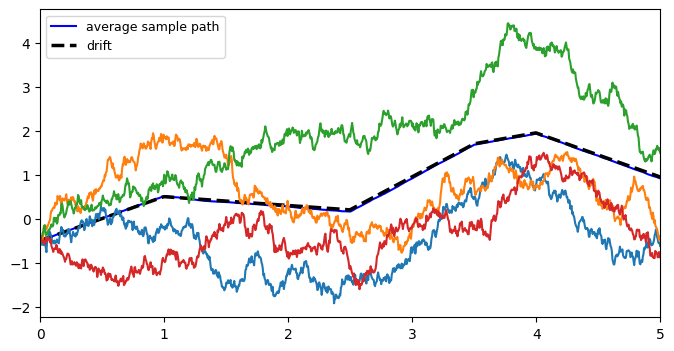

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t_, np.mean(xs, axis=0).T, label="average sample path", c="b")
ax.plot(t_, cumulative_trapezoid(drifts, t_, initial=0) + x0, label="drift", linewidth=2.5, linestyle="--", c="k")
ax.plot(t_, xs[1:5].T)
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

In [5]:
eps = 1e-3
t1s = np.linspace(eps, t1 - eps, 200)
t2s = np.linspace(t1 + eps, t2 - eps, 100)
t3s = np.linspace(t2 + eps, t3 - eps, 100)
t4s = np.linspace(t3 + eps, t4 - eps, 100)
t5s = np.linspace(t4 + eps, t5 - eps, 100)

# multi-dimensional Gauss-Legendre quadrature, in a wrapped function
# first stage, analytical
p1u_gaussfun_list, p1l_gaussfun_list = [], []
for t in t1s:
    p1u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=1))
    p1l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=-1))

# second stage, 1D integral
p2u_gaussfun_list, p2l_gaussfun_list = [], []
for t in t2s:
    p2u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=1))
    p2l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=-1))
    
# third stage, 2D integral
p3u_gaussfun_list, p3l_gaussfun_list = [], []
for t in t3s:
    p3u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=1))
    p3l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=-1))
    
# fourth stage, 3D integral
p4u_gaussfun_list, p4l_gaussfun_list = [], []
for t in t4s:
    p4u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=1))
    p4l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=-1))

# fifth stage, 4D integral
p5u_gaussfun_list, p5l_gaussfun_list = [], []
for t in t5s:
    p5u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4, mu5], t_list=[t1, t2, t3, t4], a=a, theta=theta, x0=x0, bdy=1))
    p5l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4, mu5], t_list=[t1, t2, t3, t4], a=a, theta=theta, x0=x0, bdy=-1))

In [6]:
num_sims = 10000
upper_time, lower_time, vertical_x = model.simulate_FPTD(init_cond=(0,x0), T=a/theta, a=a, theta=theta, dt=0.0005, num=num_sims)

In [7]:
len(upper_time) / num_sims, len(lower_time) / num_sims, len(vertical_x) / num_sims

(0.6245, 0.3755, 0.0)

In [8]:
counts_u, bins_u = np.histogram(upper_time, bins=40)
dt_u = bins_u[1] - bins_u[0]

counts_l, bins_l = np.histogram(lower_time, bins=40)
dt_l = bins_l[1] - bins_l[0]

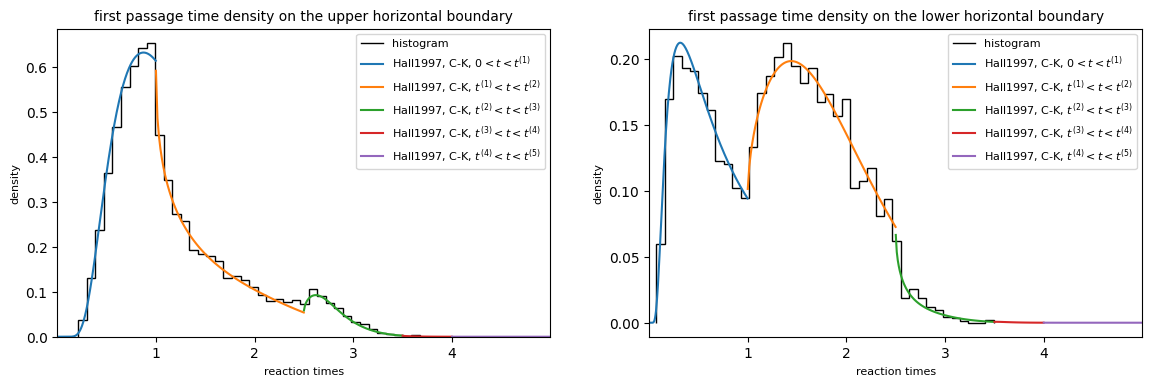

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].stairs(counts_u / num_sims / dt_u, bins_u, color="black", label="histogram")
ax[0].plot(t1s, p1u_gaussfun_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[0].plot(t2s, p2u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0].plot(t3s, p3u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0].plot(t4s, p4u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0].plot(t5s, p5u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(4)}<t<t^{(5)}$")
ax[0].legend(fontsize=8)
ax[0].set_title("first passage time density on the upper horizontal boundary", fontsize=10)
ax[0].set_xlabel("reaction times", fontsize=8)
ax[0].set_ylabel("density", fontsize=8)
ax[0].autoscale(tight=True, axis="x")

ax[1].stairs(counts_l / num_sims / dt_l, bins_l, color="black", label="histogram")
ax[1].plot(t1s, p1l_gaussfun_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[1].plot(t2s, p2l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1].plot(t3s, p3l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1].plot(t4s, p4l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1].plot(t5s, p5l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(4)}<t<t^{(5)}$")
ax[1].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[1].set_title("first passage time density on the lower horizontal boundary", fontsize=10)
ax[1].set_xlabel("reaction times", fontsize=8)
ax[1].set_ylabel("density", fontsize=8)
ax[1].autoscale(tight=True, axis="x")

plt.show()

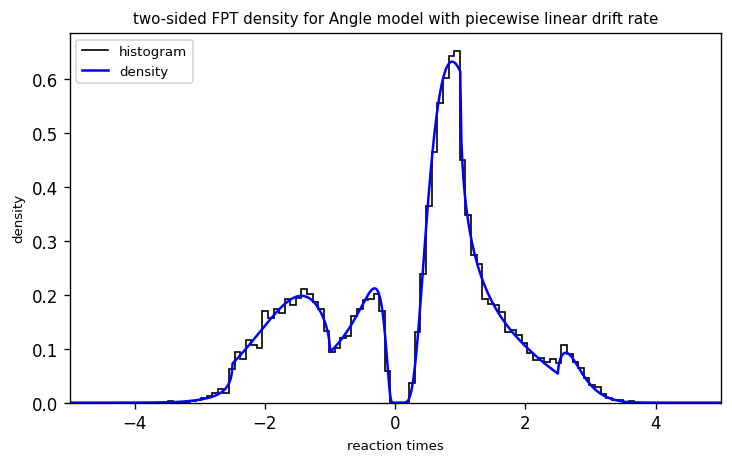

In [10]:
ts = np.hstack((t1s, t2s, t3s, t4s, t5s))
pu_gaussfun_all_list = np.hstack((p1u_gaussfun_list, p2u_gaussfun_list, p3u_gaussfun_list, p4u_gaussfun_list, p5u_gaussfun_list))
pl_gaussfun_all_list = np.hstack((p1l_gaussfun_list, p2l_gaussfun_list, p3l_gaussfun_list, p4l_gaussfun_list, p5l_gaussfun_list))

ts_all = np.hstack((-ts[::-1], ts))
p_gaussfun_all_list = np.hstack((pl_gaussfun_all_list[::-1], pu_gaussfun_all_list))

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=120)
ax.stairs(counts_u / num_sims / dt_u, bins_u, color="black", label="histogram")
ax.stairs(counts_l / num_sims / dt_l, -bins_l, color="black")
ax.plot(ts_all, p_gaussfun_all_list, c="blue", label="density")
ax.legend(fontsize=8)
ax.set_title("two-sided FPT density for Angle model with piecewise linear drift rate", fontsize=9)
ax.set_xlabel("reaction times", fontsize=8)
ax.set_ylabel("density", fontsize=8)
ax.autoscale(tight=True, axis="x")

plt.show()